PART 2: Find a model that explains the data.

For this part you can use any tool you are familiar with, be it statistical methods, machine learning or even deep learning.

Possible ideas:

regression model if you are trying to predict continuous values
classification model when you have discrete and finite labels
clustering if you want to find underlying structures of data, without prior information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
spotify_songs_df = pd.read_csv('spotify-2023.csv', encoding='latin-1')

In [3]:
# Null values in columns of float type
null_float_columns = spotify_songs_df.select_dtypes(include=['float']).isnull().sum()
print("Null values in columns of float type:")
print(null_float_columns)

# Null values in columns of object type
null_text_columns = spotify_songs_df.select_dtypes(include=['object']).isnull().sum()
print("\nNull values in columns of object type:")
print(null_text_columns)

# Null values in columns of integer type
null_int_columns = spotify_songs_df.select_dtypes(include=['int']).isnull().sum()
print("\nNull values in columns of integer type:")
print(null_int_columns)

Null values in columns of float type:
Series([], dtype: float64)

Null values in columns of object type:
track_name              0
artist(s)_name          0
streams                 0
in_deezer_playlists     0
in_shazam_charts       50
key                    95
mode                    0
dtype: int64

Null values in columns of integer type:
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
in_apple_playlists      0
in_apple_charts         0
in_deezer_charts        0
bpm                     0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64


In [4]:
#Converts non-numeric values to NaN
spotify_songs_df['in_shazam_charts'] = pd.to_numeric(spotify_songs_df['in_shazam_charts'], errors='coerce')
#Calculates the average of the numerical values in the column
mean_shazam_charts = spotify_songs_df['in_shazam_charts'].mean()
#Replace the NaN values with the calculated mean
spotify_songs_df['in_shazam_charts'].fillna(mean_shazam_charts, inplace=True)
print("Mean of in_shazam_charts:", mean_shazam_charts)

Mean of in_shazam_charts: 51.176339285714285


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [6]:
spotify_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_name            953 non-null    object 
 1   artist(s)_name        953 non-null    object 
 2   artist_count          953 non-null    int64  
 3   released_year         953 non-null    int64  
 4   released_month        953 non-null    int64  
 5   released_day          953 non-null    int64  
 6   in_spotify_playlists  953 non-null    int64  
 7   in_spotify_charts     953 non-null    int64  
 8   streams               953 non-null    object 
 9   in_apple_playlists    953 non-null    int64  
 10  in_apple_charts       953 non-null    int64  
 11  in_deezer_playlists   953 non-null    object 
 12  in_deezer_charts      953 non-null    int64  
 13  in_shazam_charts      953 non-null    float64
 14  bpm                   953 non-null    int64  
 15  key                   8

To do the model I don't have to consider all the variables but only some, so I prefer to create a copy of the dataframe and use it to do the liner regression and delete some columns that I don't need for the model.

In [7]:
spotify_songs_copy_df = spotify_songs_df.copy()

In [8]:
spotify_songs_copy_df.columns

Index(['track_name', 'artist(s)_name', 'artist_count', 'released_year',
       'released_month', 'released_day', 'in_spotify_playlists',
       'in_spotify_charts', 'streams', 'in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts', 'bpm',
       'key', 'mode', 'danceability_%', 'valence_%', 'energy_%',
       'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'],
      dtype='object')

In [9]:
spotify_songs_copy_df.drop(columns= ['track_name', 'artist(s)_name','artist_count','released_year','released_month', 'released_day','in_spotify_playlists', 'in_spotify_charts','in_apple_playlists', 'in_apple_charts',
       'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts','key','mode'], inplace=True)

In [10]:
spotify_songs_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   streams             953 non-null    object
 1   bpm                 953 non-null    int64 
 2   danceability_%      953 non-null    int64 
 3   valence_%           953 non-null    int64 
 4   energy_%            953 non-null    int64 
 5   acousticness_%      953 non-null    int64 
 6   instrumentalness_%  953 non-null    int64 
 7   liveness_%          953 non-null    int64 
 8   speechiness_%       953 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 67.1+ KB


In [11]:
spotify_songs_copy_df.head(3)

,streams,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,141381703,125,80,89,83,31,0,8,4
1,133716286,92,71,61,74,7,0,10,4
2,140003974,138,51,32,53,17,0,31,6


In [12]:
import re
# Function to extract numerical value from a string
def extract_numeric_value(entry):
    if isinstance(entry, str):
        numeric_match = re.search(r'\d+\.*\d*', entry)
        if numeric_match:
            return float(numeric_match.group())
        else:
            return np.nan
    elif isinstance(entry, (int, float)):
        return float(entry)
    else:
        return np.nan

# Applies the function to extract numeric or NaN values from the column
spotify_songs_copy_df['streams_numeric_cleaned'] = spotify_songs_copy_df['streams'].apply(extract_numeric_value)

#  Check the first few lines to see if cleaning was successful
print(spotify_songs_copy_df[['streams', 'streams_numeric_cleaned']].head())

#Function to check whether a string is concatenated (has more than one characteristic type)
def is_concatenated(entry):
    return bool(re.search(r'[A-Za-z]', entry)) and bool(re.search(r'\d', entry))

# Filter and remove rows with concatenated values in the 'streams' column
spotify_songs_copy_df = spotify_songs_copy_df[~spotify_songs_copy_df['streams'].apply(is_concatenated)]


     streams  streams_numeric_cleaned
0  141381703              141381703.0
1  133716286              133716286.0
2  140003974              140003974.0
3  800840817              800840817.0
4  303236322              303236322.0


In [13]:
# Remove the 'streams' column from the DataFrame
spotify_songs_copy_df = spotify_songs_copy_df.drop(columns=['streams'])

In [14]:
spotify_songs_copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bpm                      952 non-null    int64  
 1   danceability_%           952 non-null    int64  
 2   valence_%                952 non-null    int64  
 3   energy_%                 952 non-null    int64  
 4   acousticness_%           952 non-null    int64  
 5   instrumentalness_%       952 non-null    int64  
 6   liveness_%               952 non-null    int64  
 7   speechiness_%            952 non-null    int64  
 8   streams_numeric_cleaned  952 non-null    float64
dtypes: float64(1), int64(8)
memory usage: 74.4 KB


In [15]:
x = spotify_songs_copy_df.drop(['streams_numeric_cleaned'], axis = 1) #to make the prediction I delete the column I need to predict
y = spotify_songs_copy_df.streams_numeric_cleaned.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42) #80% of X and Y are test and 20% are train

In [16]:
ro_scaler = RobustScaler()  #RobustScaler is used to scale features by removing the median and scaling according to the quantile range
x_train_scaled = ro_scaler.fit_transform(x_train)  #fit the scaler on the training data and transform it
x_test_scaled = ro_scaler.fit_transform(x_test)  #apply the same transformation to the test data

In [19]:
model = LinearRegression()  #LinearRegression is a statistical method used to model the relationship between a dependent variable (target) and one or more independent variables (features)
model.fit(x_train_scaled, y_train)  #train the LinearRegression model using the scaled training data

LinearRegression()

In [20]:
y_pred = model.predict(x_test_scaled)  #the .predict() method computes the predicted values of the target variable based on the test features (x_test_scaled)
print(len(y_pred))
y_pred

191


array([6.85159186e+08, 4.04986922e+08, 6.12137716e+08, 4.87241186e+08,
       5.61006431e+08, 4.33785495e+08, 4.96543187e+08, 4.00020246e+08,
       2.93876023e+08, 5.46498500e+08, 5.46075145e+08, 5.67104000e+08,
       5.54238693e+08, 5.35297313e+08, 5.49885519e+08, 6.07888290e+08,
       5.33025403e+08, 6.86237588e+08, 6.51936843e+08, 6.83271781e+08,
       6.07574652e+08, 5.75998206e+08, 6.08198284e+08, 6.60770092e+08,
       5.26736275e+08, 5.00582294e+08, 5.02341036e+08, 5.18993492e+08,
       4.53175358e+08, 5.45584514e+08, 5.71642397e+08, 4.98439402e+08,
       4.90946454e+08, 5.46003481e+08, 6.11099953e+08, 3.68964815e+08,
       5.35867389e+08, 5.46689131e+08, 5.67398844e+08, 4.12901112e+08,
       5.50989438e+08, 4.74656975e+08, 4.69167870e+08, 5.31626059e+08,
       6.50429809e+08, 7.24964968e+08, 5.72450537e+08, 6.04579596e+08,
       4.65940657e+08, 5.65918149e+08, 5.05820968e+08, 6.05786385e+08,
       6.33436145e+08, 5.92517407e+08, 4.41567994e+08, 6.43745081e+08,
      

In [21]:
score = model.score(x_test_scaled, y_test)  #the .score() method computes how well the model's predictions match the actual target values
print("Coefficient of determination (R-squared):", score)

Coefficient of determination (R-squared): -0.00335047079255979


The R-squared score ranges from 0 to 1, where 1 indicates a perfect fit and 0 indicates no explanatory power. An R-squared value of -0.00335047079255979 indicates that the model is performing poorly, even worse than a simple model that predicts the average target value.

In [34]:
slope = model.coef_  #the .coef_ attribute of the LinearRegression model contains the coefficients (weights) for each feature
print('Coefficients:', slope)

slope_mean = print('Mean:', slope.mean())

Coefficients: [ -8485375.36719087 -88446575.908745    36513204.01515795
 -18570644.51411137 -35667117.84272719  -3852196.04374859
 -43047375.9142298  -49284455.80078104]
Mean: -26355067.17204699


In [33]:
intercept = model.intercept_  #the .intercept_ attribute contains the intercept of the linear regression equation
print('Intercepts:', intercept)

Intercepts: 579830801.5344857


In [23]:
r2 = r2_score(y_test, y_pred)  # The r2_score function computes the R-squared value, which measures how well the model's predictions match the actual target values
print('Coefficient of determination (R^2):', r2)

Coefficient of determination (R^2): -0.00335047079255979


The R-squared value of -0.00335047079255979 indicates that the model's performance is poor and worse than predicting the mean of the target variable. This negative value suggests that the model is not capturing the underlying patterns in the data effectively, and there may be issues with the model choice, feature selection, or data quality.

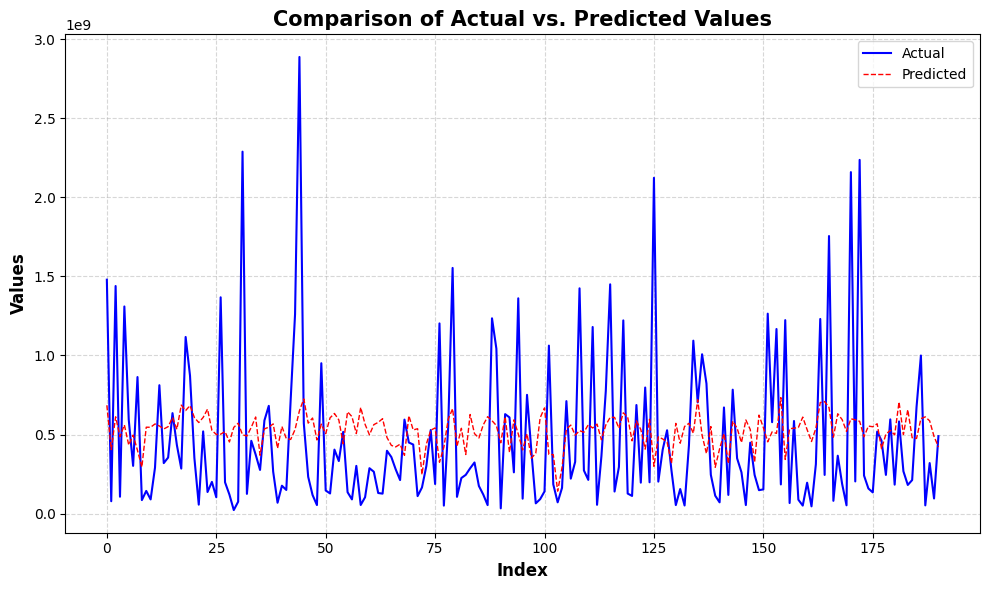

In [25]:
plt.figure(figsize = (10, 6))
plt.plot(y_test, color = 'blue', linewidth = 1.5, label = 'Actual')
plt.plot(y_pred, linestyle = '--', color = 'red', linewidth = 1, label = 'Predicted')
plt.xlabel('Index', fontsize = 12, fontweight = 'bold', color = 'black')
plt.ylabel('Values', fontsize = 12, fontweight = 'bold', color = 'black')
plt.title('Comparison of Actual vs. Predicted Values', fontsize = 15, fontweight = 'bold', color = 'black')
plt.xticks(fontsize = 10, color = 'black')
plt.yticks(fontsize = 10, color = 'black')
plt.grid(True, linestyle = '--', alpha = 0.5)
plt.legend()

plt.tight_layout()
plt.show()

Already from the numerical values it could be expected that the graph would be inaccurate. Here it can actually be seen that the actual values are quite discordant with the predicted values.

In [37]:
#Inizialize an empty list to store the sum squared of the distance for each number of clusters
Sum_of_squared_distances = []
#Fit the KMeans model to the data with a range of different numbers of clusters
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(spotify_songs_copy_df)
    Sum_of_squared_distances.append(km.inertia_)

In [38]:
for n_clusters in range(2,15):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(spotify_songs_copy_df)
    centers = clusterer.cluster_centers_

    score = silhouette_score (spotify_songs_copy_df, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.7415657882311354)
For n_clusters = 3, silhouette score is 0.671680478455892)
For n_clusters = 4, silhouette score is 0.639180935701872)
For n_clusters = 5, silhouette score is 0.5778465996257419)
For n_clusters = 6, silhouette score is 0.5876317752944471)
For n_clusters = 7, silhouette score is 0.5593010807561193)
For n_clusters = 8, silhouette score is 0.564456750068744)
For n_clusters = 9, silhouette score is 0.5516844058362058)
For n_clusters = 10, silhouette score is 0.5424656887668418)
For n_clusters = 11, silhouette score is 0.5554707569505333)
For n_clusters = 12, silhouette score is 0.5441815167186365)
For n_clusters = 13, silhouette score is 0.5398957937883355)
For n_clusters = 14, silhouette score is 0.5457539083763423)


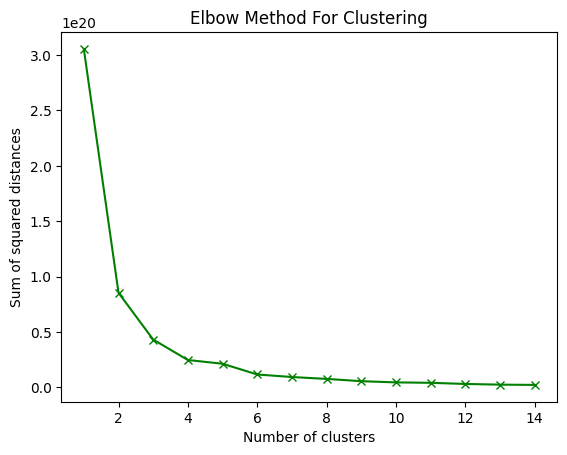

In [39]:
#Plot the sum squared distances for each number of cluster
plt.plot(K, Sum_of_squared_distances, 'gx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Clustering')
plt.show()

In [40]:
#inizialize the kmeans model, with k=4 because we can see an elbow point in corrispondence of 4
kmeans = KMeans(n_clusters=4)
kmeans.fit(spotify_songs_copy_df)

KMeans(n_clusters=4)

In [41]:
#To generate the clusters with the KMeans algorithm, we can use the predict() method on the fitted KMeans model
clusters=kmeans.predict(spotify_songs_copy_df)
print(clusters[:10])

[3 3 3 1 3 3 1 3 3 1]


In [42]:
from sklearn.metrics import silhouette_score
#Evaluate the quality of the generated clusters
## Calculate the silhouette score for the generated clusters
#remark silhouette index go from -1 and 1
silhouette_score(spotify_songs_copy_df,clusters)

0.639180935701872

In [43]:
# PCA to reduce our data to 2 dimensions for visualisation
from sklearn.decomposition import PCA
y_kmeans = kmeans.predict(spotify_songs_copy_df)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(spotify_songs_copy_df)

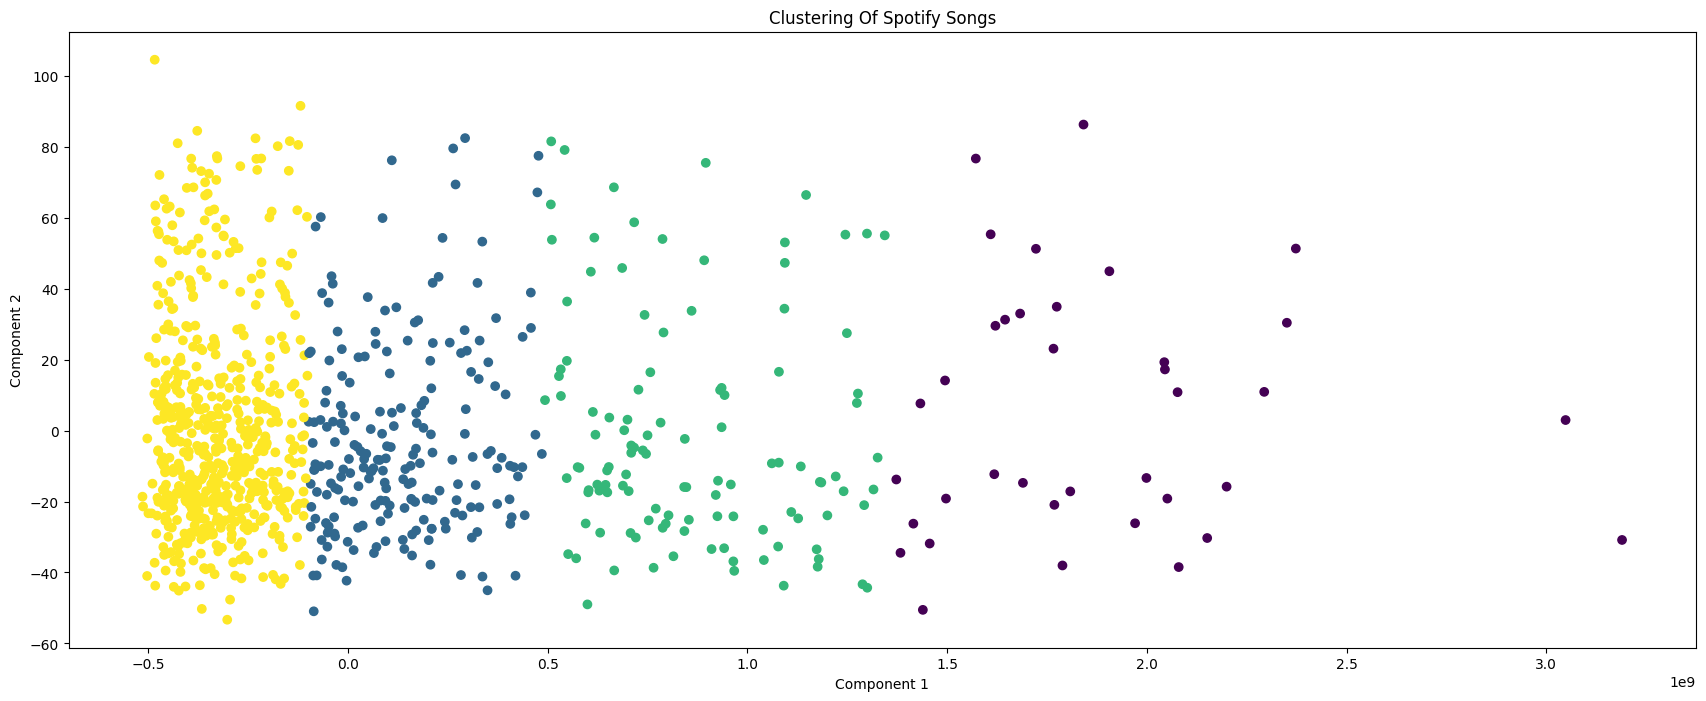

In [44]:
#plot
# Plot the data points on a scatter plot
# Coloring the data points according to their cluster assignment
plt.figure(figsize=(21,8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters)
plt.title('Clustering Of Spotify Songs')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

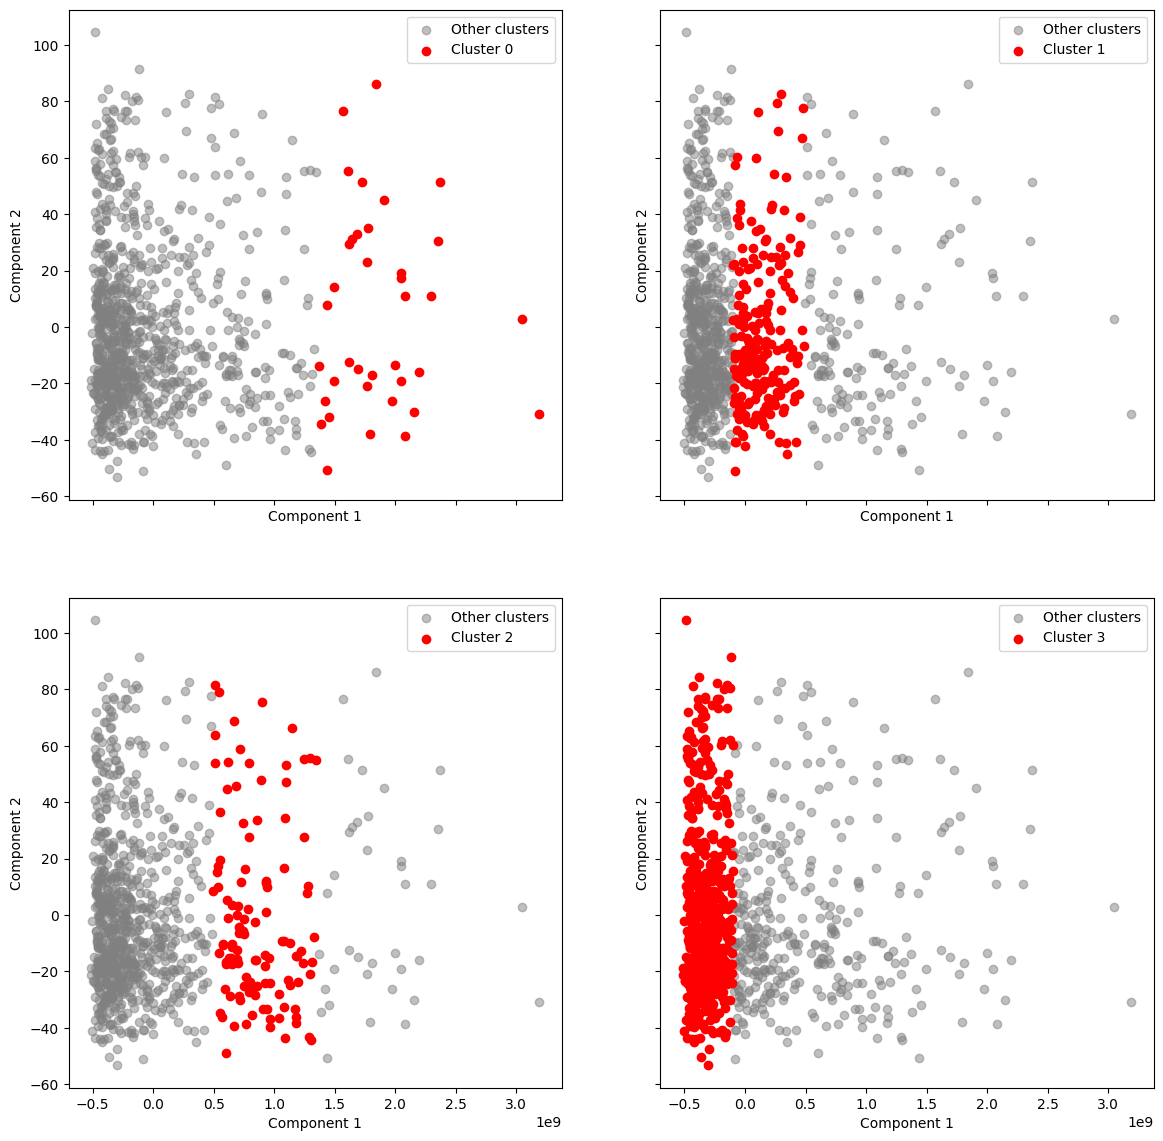

In [45]:
# Get the unique cluster assignments
unique_clusters = np.unique(clusters)

# Create a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,14), sharex=True, sharey=True)

# Flatten the array of subplots to make it easier to iterate over
axs = axs.flatten()

# Iterate over the clusters
for i, cluster in enumerate(unique_clusters):
    # Select the data points belonging to the current cluster
    df_cluster = principal_components[clusters == cluster]
    
    # Select the data points belonging to other clusters
    df_other_clusters = principal_components[clusters != cluster]
    
    # Plot the data points belonging to other clusters in gray
    axs[i].scatter(df_other_clusters[:, 0], df_other_clusters[:, 1], c='gray', label='Other clusters', alpha=0.5)
    
    # Plot the data points belonging to the current cluster with a different color
    axs[i].scatter(df_cluster[:, 0], df_cluster[:, 1], c='red', label='Cluster {}'.format(cluster))
    
    # Set the x and y labels for the current subplot
    axs[i].set_xlabel('Component 1')
    axs[i].set_ylabel('Component 2')
    
    # Add a legend to the current subplot
    axs[i].legend()

plt.show()


In [46]:
# First, let's create a new dataframe with the cluster assignments as a column
clustered_df = spotify_songs_copy_df.copy()
clustered_df['cluster'] = clusters

In [53]:
# Now, we can examine the characteristics of the individual clusters
# For example, we can group the data by cluster and compute the mean of each column
cluster_means = clustered_df.groupby('cluster').mean()
print(cluster_means)

# We can also compare the clusters to each other by creating a plot of the cluster means
# This can help us to see how the clusters differ from each other

#cluster_means.plot(kind='bar',figsize=(20,15))
#plt.title('Cluster Characteristics')
#plt.legend(bbox_to_anchor=(1.0, 1.0))
#plt.show()

                bpm  danceability_%  valence_%   energy_%  acousticness_%  \
cluster                                                                     
0        117.540541       62.027027  49.891892  60.513514       31.621622   
1        125.202899       66.314010  50.893720  64.570048       24.048309   
2        123.321739       64.278261  48.278261  64.904348       25.339130   
3        121.792580       68.052277  52.286678  64.283305       28.190556   

         instrumentalness_%  liveness_%  speechiness_%  \
cluster                                                  
0                  0.054054   15.405405       8.081081   
1                  1.555556   17.739130       9.067633   
2                  0.669565   17.973913       8.373913   
3                  1.865093   18.602024      10.983137   

         streams_numeric_cleaned  
cluster                           
0                   2.383958e+09  
1                   6.457436e+08  
2                   1.369015e+09  
3            